In [1]:
import pandas as pd
import geopandas as gpd
import pathlib
import numpy as np
import geojson

import matplotlib.pyplot as plt

import dtv_backend.climate
import dtv_backend.fis

/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Velocities as function of river discharge
This notebook determines the velocities as a function of river discharge for the Dutch rivers. These are based on the betrekkingslijnen, the Q-h relationship.  The data are stored on "km marks", markings each km along the fairway. 

We follow the following steps:
- Download information about markings in the river
- Open and read the xls file containing information of the Q-h relationship
- Do a spatial join between the two datasets
- Define interpolation functions over Q and over space. 


In [2]:
# general settings, the data where information is stored
data_dir = pathlib.Path('~/data/river/dtv/migena/Rijntakken')

download = False

epsg_utm31n = 32631
epsg_wgs84 = 4326
epsg_rd = 28992

value_column = 'velocity'


### Download 
Here we get extra information on the fairway from Rijkswaterstaat. We also need to connect it to the Fairway Information System. 

In [3]:
if download:
    !wget -c -q -O {data_dir / 'kmmarkeringen.geojson' } 'https://geodata.nationaalgeoregister.nl/nwbvaarwegen/wfs?request=GetFeature&service=WFS&version=2.0.0&outputFormat=json&typeNames=nwbvaarwegen:kmmarkeringen'
    !wget -c -q -O {data_dir / 'vaarwegvakken.geojson' } 'https://geodata.nationaalgeoregister.nl/nwbvaarwegen/wfs?request=GetFeature&service=WFS&version=1.1.0&outputFormat=json&typeName=vaarwegvakken'

kmmarkering_path = data_dir / 'kmmarkeringen.geojson'
vaarwegvakken_path = data_dir / 'vaarwegvakken.geojson'


### Read xls 
Here we read the waterlevels that are a function of the Lobith discharge (Q).  These are stored in separate sheets.

In [4]:
lobith_df = pd.read_csv(data_dir / 'velocity' / 'per_rkm_location' / 'rkm_join_allQ_20211015.csv')
lobith_df.head()


,X,Y,MODELKILOM,KENMERK,KILOMETER,Q1020,Q2000,Q2700,Q4000,Q4450,Q6000,Q8000,Q10000,Q12000,Q16000
0,212075,427009,854.00_BR,01 BR 854.00,854,1.11,1.34,1.47,1.58,1.60,1.66,1.76,1.90,2.03,2.25
1,211085,427120,855.00_BR,01 BR 855.00,855,1.13,1.39,1.54,1.62,1.70,1.85,1.87,1.94,2.06,2.32
2,210161,427485,856.00_BR,01 BR 856.00,856,1.24,1.46,1.60,1.64,1.69,1.85,1.85,1.85,1.92,2.07
3,209315,427994,857.00_BR,01 BR 857.00,857,1.04,1.28,1.50,1.59,1.65,1.84,1.87,1.89,1.88,1.97
4,208398,428422,858.00_BR,01 BR 858.00,858,1.01,1.26,1.43,1.63,1.69,1.86,1.99,2.07,2.08,2.18


### Data wrangling
Now we have to reorganize the data a bit before we can do a spatial join. We need an integer kilometer mark

In [5]:
columns = ['X', 'Y', 'MODELKILOM', 'KENMERK', 'KILOMETER']
group_columns = ['X', 'Y', 'MODELKILOM', 'KENMERK']


In [6]:
lobith_flat = lobith_df.melt(id_vars=columns, value_name=value_column, var_name='discharge')
lobith_flat['discharge'] = lobith_flat.discharge.apply(lambda x:  float(x.replace('Q', '')))
geometry = gpd.points_from_xy(lobith_flat['X'], lobith_flat['Y'])
lobith_flat_gdf = gpd.GeoDataFrame(lobith_flat, geometry=geometry)
lobith_flat_gdf['river'] = lobith_flat_gdf.KENMERK.apply(lambda x: x.split()[1])
lobith_flat_gdf = lobith_flat_gdf.rename(columns={'KILOMETER': 'km_markering'})
lobith_flat_gdf['km_markering_int'] = lobith_flat_gdf.km_markering.astype('int')
lobith_flat_gdf['discharge_location'] = 'Lobith'
lobith_flat_gdf = lobith_flat_gdf.set_crs(epsg_rd).to_crs(epsg_wgs84)


### Spatial join
Now we connect the kilometer markings with the data. This way we can geolocate the waterlevels on points on the river.


In [7]:
lobith_flat_gdf
vwv_gdf = gpd.read_file(vaarwegvakken_path)
river_with_discharges_gdf = gpd.sjoin_nearest(lobith_flat_gdf, vwv_gdf.to_crs(epsg_wgs84)[['vrt_code', 'vwk_id', 'geometry']], how='left')



/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/geopandas/array.py:341: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [8]:
river_with_discharges_gdf.to_file(f'../../dtv_backend/data/river_{value_column}.geojson')

river_interpolator_gdf = dtv_backend.climate.create_river_interpolator_gdf(river_with_discharges_gdf, value_column=value_column)
river_interpolator_gdf.to_pickle(f'../../dtv_backend/data/river_{value_column}_interpolator_gdf.pickle')


/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Service implementation
This part shows how to use the river_with_discharges geojson in a service.

In [9]:
# our input
climate = {
    "discharge_lobith": 1000,
    "discharge_st_pieter": 300
}

river_with_discharges_gdf = dtv_backend.climate.get_river_with_discharges_gdf(value_column="velocity")

In [10]:
river_with_discharges_gdf

,X,Y,MODELKILOM,KENMERK,km_markering,discharge,velocity,river,km_markering_int,discharge_location,index_right,vrt_code,vwk_id,geometry
0,212075,427009,854.00_BR,01 BR 854.00,854,1020.0,1.11,BR,854,Lobith,3659,101,5640,POINT (6.21518 51.82876)
1,211085,427120,855.00_BR,01 BR 855.00,855,1020.0,1.13,BR,855,Lobith,3659,101,5640,POINT (6.20084 51.82986)
2,210161,427485,856.00_BR,01 BR 856.00,856,1020.0,1.24,BR,856,Lobith,3659,101,5640,POINT (6.18749 51.83323)
3,209315,427994,857.00_BR,01 BR 857.00,857,1020.0,1.04,BR,857,Lobith,3659,101,5640,POINT (6.17530 51.83789)
4,208398,428422,858.00_BR,01 BR 858.00,858,1020.0,1.01,BR,858,Lobith,3660,101,5641,POINT (6.16206 51.84182)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3465,191370,507713,995.00_IJ,06 IJ 995.00,995,16000.0,2.08,IJ,995,Lobith,3377,084,6076,POINT (5.92349 52.55582)
3466,190763,508500,996.00_IJ,06 IJ 996.00,996,16000.0,2.07,IJ,996,Lobith,1597,084,1426,POINT (5.91462 52.56293)
3467,189950,509067,997.00_IJ,06 IJ 997.00,997,16000.0,2.23,IJ,997,Lobith,1597,084,1426,POINT (5.90269 52.56808)
3468,189107,509572,998.00_IJ,06 IJ 998.00,998,16000.0,2.13,IJ,998,Lobith,1559,084,1421,POINT (5.89031 52.57267)


<AxesSubplot:>

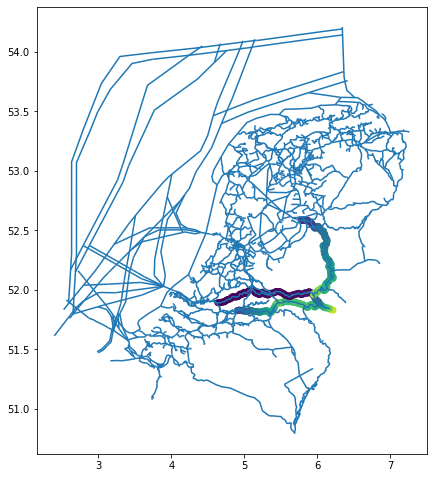

In [11]:
# the lowest diarchge scenario is 703.3, select it and plot the waterlevels
fig, ax = plt.subplots(figsize=(7, 13))
vwv_gdf.to_crs(epsg_wgs84).plot(ax=ax)
river_with_discharges_gdf.query('discharge == 1020').plot(value_column, ax=ax)

### Interpolation over Q

In [12]:
river_interpolator_gdf = dtv_backend.climate.get_river_interpolator_gdf(value_column=value_column)


Text(0, 0.5, 'velocity [m w.r.t NAP] ')

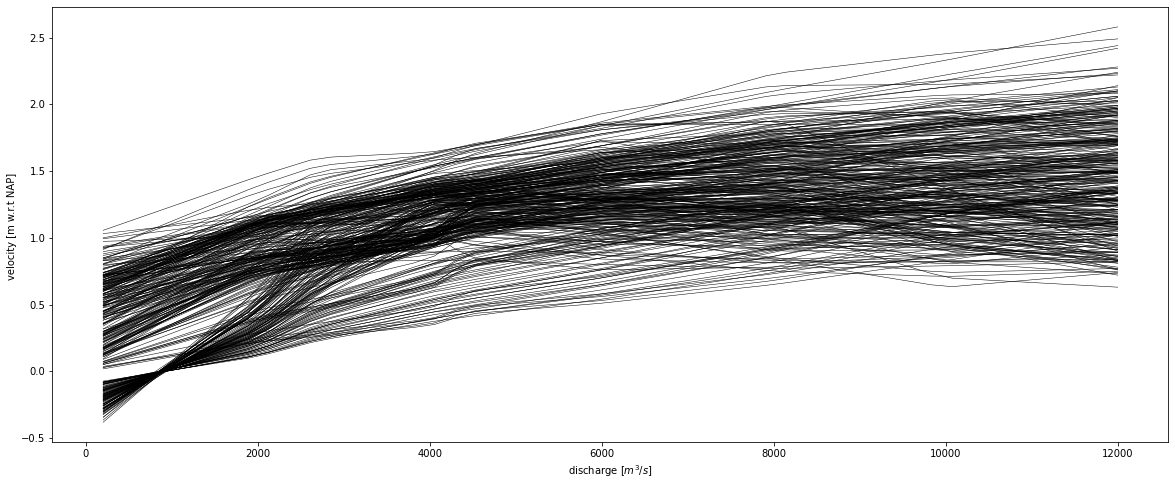

In [13]:
# plot at one location
fig, ax = plt.subplots(figsize=(20, 8))
discharge = np.linspace(200, 12000)
velocity = river_interpolator_gdf.query('discharge_location == "Lobith"')['interpolate'].apply(lambda x: pd.Series(x(discharge)))
ax.plot(discharge, velocity.values.T, 'k-', alpha=1, linewidth=0.5);
ax.set_xlabel('discharge [$m^3/s$]')
ax.set_ylabel('velocity [m w.r.t NAP] ')
# ax.set_ylim(0, 50)

### Interpolation over space

In [14]:
import networkx as nx
import shapely.geometry

FG = nx.read_gpickle('../fis-network/result/network_digital_twin_v0.3.pickle')
for n, node in FG.nodes.items():
    node['geometry'] = shapely.geometry.shape(node['geometry'])
for e, edge in FG.edges.items():
    edge['geometry'] = shapely.geometry.shape(edge['geometry'])


In [15]:


def velocities(climate):
    result = dtv_backend.climate.interpolated_values_for_climate(
        climate=climate, graph=FG,
        river_interpolator_gdf=river_interpolator_gdf, 
        epsg=epsg_utm31n, 
        value_column=value_column
    )
    response = result._to_geo()
    return response

%timeit resp = velocities(climate)


/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


61.1 ms ± 589 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


<AxesSubplot:>

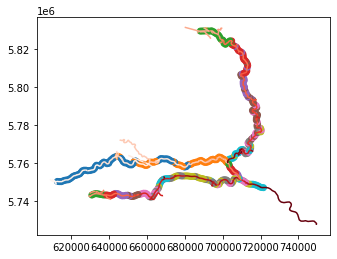

In [16]:
fig, ax = plt.subplots()
dtv_backend.climate.value_for_climate(
    river_interpolator_gdf=river_interpolator_gdf, 
    climate=climate, 
    value_column=value_column
).to_crs(epsg_utm31n).plot(value_column, ax=ax)
dtv_backend.climate.interpolated_values_for_climate(
    climate=climate, 
    graph=FG, 
    river_interpolator_gdf=river_interpolator_gdf, 
    value_column=value_column
).plot(value_column, ax=ax, cmap='Reds')
